In [1]:
from astropy import units as u
from astropy import time

import numpy as np

from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter


# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris


solar_system_ephemeris.set("jpl")

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\poliastro\core\_jit.py:29: UserWarning: Could not import numba package. All poliastro functions will work properly but the CPU intensive algorithms will be slow. Consider installing numba to boost performance.
  warnings.warn(


<ScienceState solar_system_ephemeris: 'jpl'>

In [2]:
# Initial data
date_launch = time.Time("2035-07-15 00:02", scale="utc").tdb
date_arrival = time.Time("2035-10-13 00:17", scale="utc").tdb
earth = Ephem.from_body(Earth, time_range(date_launch, end=date_arrival))
mars = Ephem.from_body(Mars, time_range(date_launch, end=date_arrival))
# Solve for departure and target orbits
ss_earth = Orbit.from_ephem(Sun, earth, date_launch)
ss_mars = Orbit.from_ephem(Sun, mars, date_arrival)
# Solve for the transfer maneuver
man_lambert = Maneuver.lambert(ss_earth, ss_mars)

# Get the transfer and final orbits
ss_trans, ss_target = ss_earth.apply_maneuver(man_lambert, intermediate=True)
#propogate orbit out to Mars
ss_final = ss_trans.propagate(date_arrival-date_launch-0.002*u.day)


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



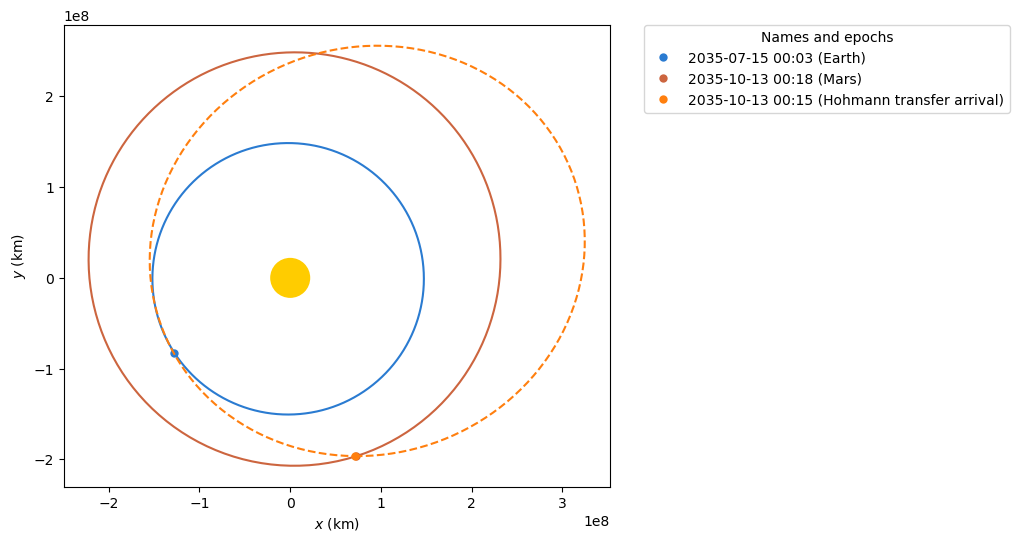

In [3]:

# We can check new bodies positions
plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(Earth,  date_launch, label="Earth")
plotter.plot_body_orbit(Mars,  date_arrival, label="Mars")

plotter.plot(ss_final, color="C1", label="Hohmann transfer arrival")


[ -920.26314673 -4193.84223821 -1758.69704672] km
4486 x -6149 km x 24.9 deg (MarsICRS) orbit around Mars (♂) at epoch 2035-10-13 00:18:09.182 (TDB)
arrival VPea 8.364200536293119 km / s
arrival C3 69.9598506113261 km2 / s2


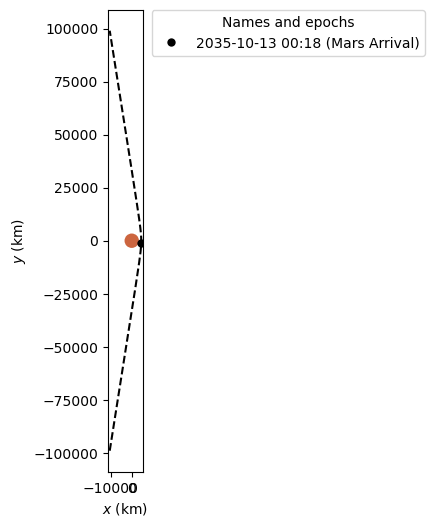

In [4]:



#arrival at Mars
#solve for arrival at Mars from ss_final
r_mars, v_mars = ss_mars.r,ss_mars.v
r_sc_arriv = ss_final.r-r_mars
v_sc_arriv = ss_final.v-v_mars
print(r_sc_arriv)

arrival_orbit = Orbit.from_vectors(Mars,r_sc_arriv,v_sc_arriv,epoch=date_arrival)
print(arrival_orbit)

mars_plotter = StaticOrbitPlotter()

mars_plotter.plot(arrival_orbit, label="Mars Arrival", color="k")


c3 = (arrival_orbit.v**2).sum()
print(f"arrival VPea {np.sqrt(c3)}")
print(f"arrival C3 {c3}")

#crude calculation of max G
#a_centrip = a_neg_lift


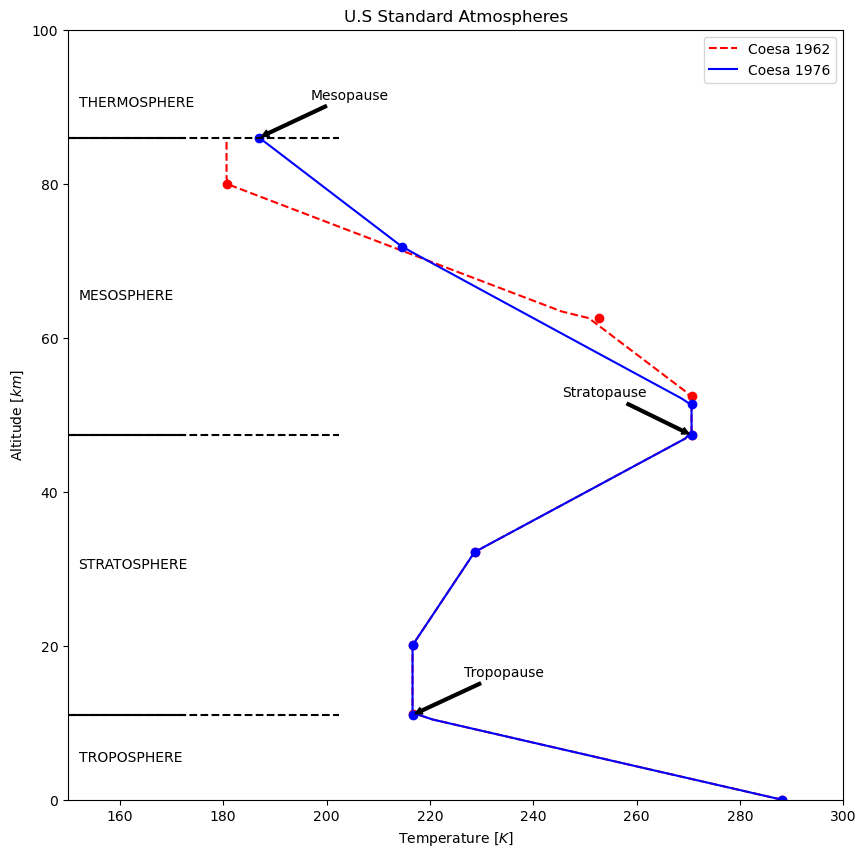

In [5]:
from astropy import units as u

from matplotlib import pyplot as plt
import numpy as np

from poliastro.earth.atmosphere import COESA62, COESA76
# We build the atmospheric instances
coesa62 = COESA62()
coesa76 = COESA76()

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("U.S Standard Atmospheres")

# Collect all atmospheric models and define their plotting properties
atm_models = {
    coesa62: ["--r", "r", "Coesa 1962"],
    coesa76: ["-b", "b", "Coesa 1976"],
}

# Solve atmospheric temperature for each of the models
for atm in atm_models:
    z_span = np.linspace(0, 86, 100) * u.km
    T_span = np.array([]) * u.K
    for z in z_span:
        # We discard density and pressure
        T = atm.temperature(z)
        T_span = np.append(T_span, T)

    # Temperature plot
    ax.plot(T_span, z_span, atm_models[atm][0], label=atm_models[atm][-1])
    ax.plot(atm.Tb_levels[:8], atm.zb_levels[:8], atm_models[atm][1] + "o")
    ax.set_xlim(150, 300)
    ax.set_ylim(0, 100)
    ax.set_xlabel("Temperature $[K]$")
    ax.set_ylabel("Altitude $[km]$")
    ax.legend()

# Add some information on the plot
ax.annotate(
    "Tropopause",
    xy=(coesa76.Tb_levels[1].value, coesa76.zb_levels[1].value),
    xytext=(coesa76.Tb_levels[1].value + 10, coesa76.zb_levels[1].value + 5),
    arrowprops=dict(arrowstyle="simple", facecolor="black"),
)
ax.annotate(
    "Stratopause",
    xy=(coesa76.Tb_levels[4].value, coesa76.zb_levels[4].value),
    xytext=(coesa76.Tb_levels[4].value - 25, coesa76.zb_levels[4].value + 5),
    arrowprops=dict(arrowstyle="simple", facecolor="black"),
)
ax.annotate(
    "Mesopause",
    xy=(coesa76.Tb_levels[7].value, coesa76.zb_levels[7].value),
    xytext=(coesa76.Tb_levels[7].value + 10, coesa76.zb_levels[7].value + 5),
    arrowprops=dict(arrowstyle="simple", facecolor="black"),
)

# Layers in the atmosphere
for h in [11.019, 47.350, 86]:
    ax.axhline(h, color="k", linestyle="--", xmin=0.0, xmax=0.35)
    ax.axhline(h, color="k", linestyle="-", xmin=0.0, xmax=0.15)

layer_names = {
    "TROPOSPHERE": 5,
    "STRATOSPHERE": 30,
    "MESOSPHERE": 65,
    "THERMOSPHERE": 90,
}
for name in layer_names:
    ax.annotate(
        name,
        xy=(152, layer_names[name]),
        xytext=(152, layer_names[name]),
    )

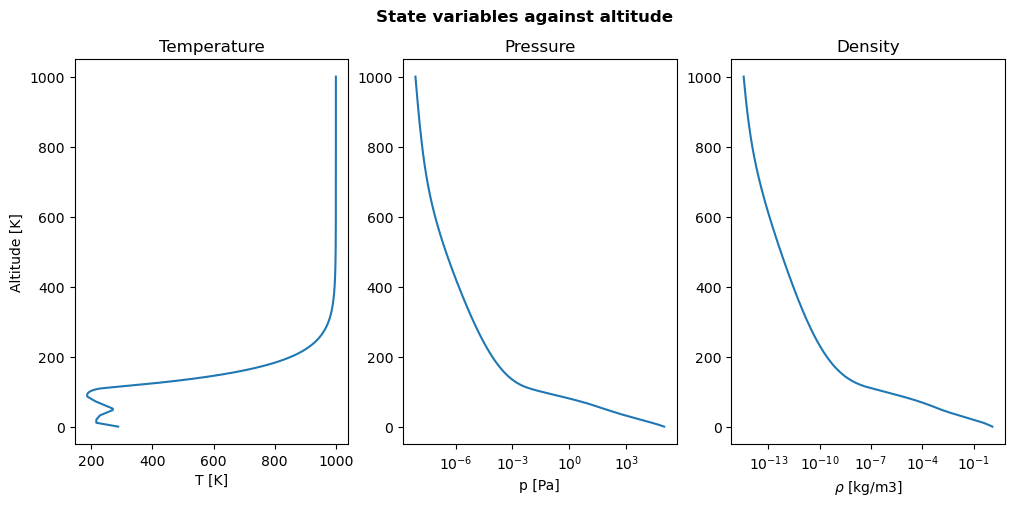

In [6]:
# We create the basis for the figure
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("State variables against altitude", fontweight="bold")

# Complete altitude range and initialization of state variables sets
alt_span = np.linspace(0, 1000, 1001) * u.km
T_span = np.array([]) * u.K
p_span = np.array([]) * u.Pa
rho_span = np.array([]) * u.kg / u.m**3

# We solve for each property at given altitude
for alt in alt_span:
    T, p, rho = coesa76.properties(alt)
    T_span = np.append(T_span, T)
    p_span = np.append(p_span, p.to(u.Pa))
    rho_span = np.append(rho_span, rho)

# Temperature plot
axs[0].set_title("Temperature")
axs[0].set_xlabel("T [K]")
axs[0].set_ylabel("Altitude [K]")
axs[0].plot(T_span, alt_span)

# Pressure plot
axs[1].set_title("Pressure")
axs[1].set_xlabel("p [Pa]")
axs[1].plot(p_span, alt_span)
axs[1].set_xscale("log")

# Density plot
axs[2].set_title("Density")
axs[2].set_xlabel(r"$\rho$ [kg/m3]")
axs[2].plot(rho_span, alt_span)
axs[2].set_xscale("log")